# Lab03 - NB + KNN + DT


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from dslabs_functions import *

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from pandas import read_csv, DataFrame

filename = "data/CFD_smote.csv"
target = "CLASS"
file_tag = "CFD"
file = "CFD"
data: DataFrame = read_csv(filename, na_values="")

data.shape

(7072, 87)

Labels=[0, 1]


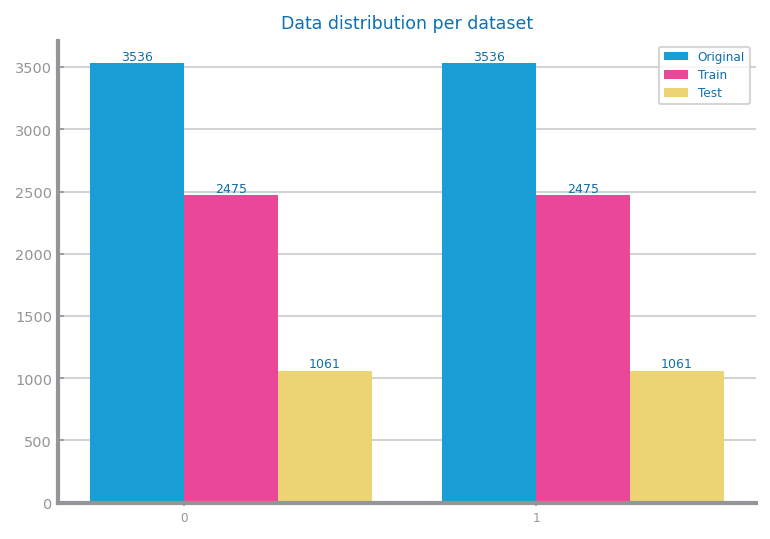

In [3]:
from numpy import array, ndarray
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart
from pandas import concat

# Identificar as labels (classes) do target
labels: list = list(data[target].unique())
labels.sort()
print(f"Labels={labels}")

positive: int = 1
negative: int = 0

# Verificar a distribuição inicial
values: dict[str, list[int]] = {
    "Original": [
        len(data[data[target] == negative]),
        len(data[data[target] == positive]),
    ]
}

# Separar X (features) e y (target)
y: array = data.pop(target).to_list()  # Remove o target do dataset
X: ndarray = data.values  # Obtém os valores das features como um ndarray

# Dividir os dados em treino e teste (antes de aplicar MinMaxScaler)
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

# Aplicar MinMaxScaler (apenas aos dados de treino e teste separadamente)
scaler = MinMaxScaler(feature_range=(0, 1))
trnX_scaled = scaler.fit_transform(trnX)  # Ajustar e transformar os dados de treino
tstX_scaled = scaler.transform(tstX)      # Apenas transformar os dados de teste

# Reconstruir os DataFrames de treino e teste, incluindo o target
train: DataFrame = concat(
    [DataFrame(trnX_scaled, columns=data.columns), DataFrame(trnY, columns=[target])],
    axis=1,
)
train.to_csv(f"data/{file_tag}_train.csv", index=False)

test: DataFrame = concat(
    [DataFrame(tstX_scaled, columns=data.columns), DataFrame(tstY, columns=[target])],
    axis=1,
)
test.to_csv(f"data/{file_tag}_test.csv", index=False)

# Atualizar a distribuição de classes nos conjuntos de treino e teste
values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

# Plotar a distribuição de classes
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()


## Train Test Split

In [4]:
# from numpy import array, ndarray
# from pandas import read_csv, DataFrame

# labels: list = list(data[target].unique())
# labels.sort()
# print(f"Labels={labels}")

# positive: int = 1
# negative: int = 0
# values: dict[str, list[int]] = {
#     "Original": [
#         len(data[data[target] == negative]),
#         len(data[data[target] == positive]),
#     ]
# }

# y: array = data.pop(target).to_list()
# X: ndarray = data.values

## Balancing data

In [5]:
# from pandas import concat
# from matplotlib.pyplot import figure, show
# from sklearn.model_selection import train_test_split
# from dslabs_functions import plot_multibar_chart


# trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

# train: DataFrame = concat(
#     [DataFrame(trnX, columns=data.columns), DataFrame(trnY, columns=[target])], axis=1
# )
# train.to_csv(f"data/{file_tag}_train.csv", index=False)

# test: DataFrame = concat(
#     [DataFrame(tstX, columns=data.columns), DataFrame(tstY, columns=[target])], axis=1
# )
# test.to_csv(f"data/{file_tag}_test.csv", index=False)

# values["Train"] = [
#     len(train[train[target] == negative]),
#     len(train[train[target] == positive]),
# ]
# values["Test"] = [
#     len(test[test[target] == negative]),
#     len(test[test[target] == positive]),
# ]

# figure(figsize=(6, 4))
# plot_multibar_chart(labels, values, title="Data distribution per dataset")
# show()

## Gaussian Naive Bayes 

In [6]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(trnX, trnY)
pred_trnY: array = clf.predict(trnX)
print(f"Score over Train: {clf.score(trnX, trnY):.3f}")
print(f"Score over Test: {clf.score(tstX, tstY):.3f}")

Score over Train: 0.565
Score over Test: 0.563


In [7]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

pred_tstY: array = clf.predict(tstX)

acc: float = accuracy_score(tstY, pred_tstY)
recall: float = recall_score(tstY, pred_tstY)
prec: float = precision_score(tstY, pred_tstY)
print(f"accuracy={acc:.3f} recall={recall:.3f} precision={prec:.3f}")

accuracy=0.563 recall=0.978 precision=0.535


### Confusion Matrix

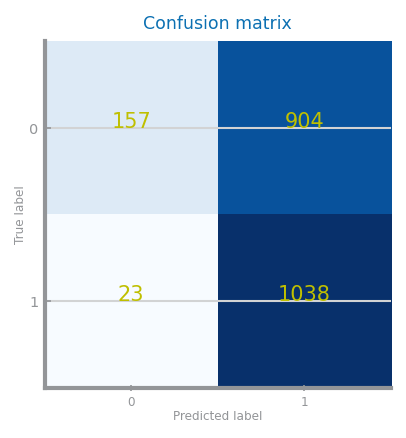

In [8]:
from itertools import product
from numpy import ndarray, set_printoptions, arange
from matplotlib.pyplot import gca, cm
from matplotlib.axes import Axes
from pandas import unique
from sklearn.metrics import confusion_matrix

labels: list = list(unique(tstY))
labels.sort()

prdY: array = clf.predict(tstX)
cnf_mtx_tst: ndarray = confusion_matrix(tstY, prdY, labels=labels)

def plot_confusion_matrix(cnf_matrix: ndarray, classes_names: ndarray, ax: Axes = None) -> Axes:  # type: ignore
    if ax is None:
        ax = gca()
    title = "Confusion matrix"
    set_printoptions(precision=2)
    tick_marks: ndarray = arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cnf_matrix, interpolation="nearest", cmap=cm.Blues)

    for i, j in product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        ax.text(
            j, i, format(cnf_matrix[i, j], "d"), color="y", horizontalalignment="center"
        )
    return ax


figure()
plot_confusion_matrix(cnf_mtx_tst, labels)
show()

### ROC chart

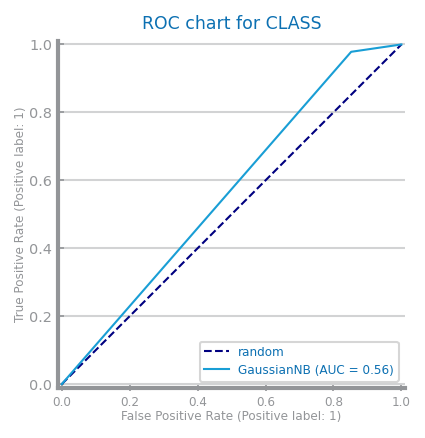

In [9]:
from sklearn.metrics import RocCurveDisplay
from config import ACTIVE_COLORS


def plot_roc_chart(tstY: ndarray, predictions: dict, ax: Axes = None, target: str = "class") -> Axes:  # type: ignore
    if ax is None:
        ax = gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel("FP rate")
    ax.set_ylabel("TP rate")
    ax.set_title("ROC chart for %s" % target)

    ax.plot(
        [0, 1],
        [0, 1],
        color="navy",
        label="random",
        linewidth=1,
        linestyle="--",
        marker="",
    )
    models = list(predictions.keys())
    for i in range(len(models)):
        RocCurveDisplay.from_predictions(
            y_true=tstY,
            y_pred=predictions[models[i]],
            name=models[i],
            ax=ax,
            color=ACTIVE_COLORS[i],
            linewidth=1,
        )
    ax.legend(loc="lower right", fontsize="xx-small")
    return ax


figure()
plot_roc_chart(tstY, {"GaussianNB": prdY}, target=target)
show()

## NB Evaluation

<Figure size 600x450 with 0 Axes>

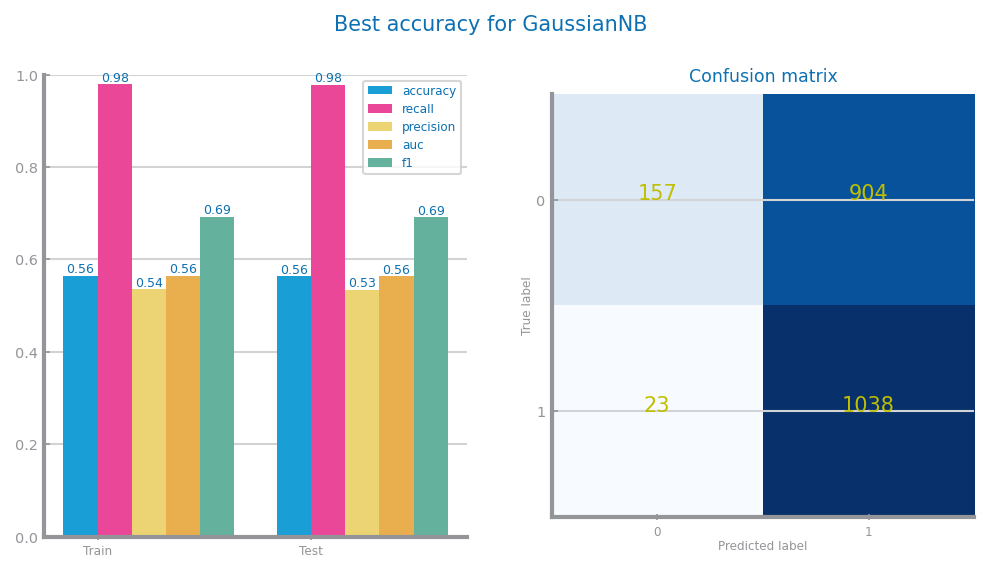

In [10]:
from typing import Callable
from matplotlib.figure import Figure
from matplotlib.pyplot import subplots, savefig, figure
from sklearn.metrics import roc_auc_score, f1_score
from dslabs_functions import plot_multibar_chart, HEIGHT

CLASS_EVAL_METRICS: dict[str, Callable] = {
    "accuracy": accuracy_score,
    "recall": recall_score,
    "precision": precision_score,
    "auc": roc_auc_score,
    "f1": f1_score,
}


def plot_evaluation_results(
    model, trn_y, prd_trn, tst_y, prd_tst, labels: ndarray
) -> ndarray:
    evaluation: dict = {}
    for key in CLASS_EVAL_METRICS:
        evaluation[key] = [
            CLASS_EVAL_METRICS[key](trn_y, prd_trn),
            CLASS_EVAL_METRICS[key](tst_y, prd_tst),
        ]

    params_st: str = "" if () == model["params"] else str(model["params"])
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    fig.suptitle(f'Best {model["metric"]} for {model["name"]} {params_st}')
    plot_multibar_chart(["Train", "Test"], evaluation, ax=axs[0], percentage=True)

    cnf_mtx_tst: ndarray = confusion_matrix(tst_y, prd_tst, labels=labels)
    plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1])
    return axs


eval_metric: str = "accuracy"  # Define the evaluation metric

model_description: dict = {"name": "GaussianNB", "metric": eval_metric, "params": ()}

prd_trn: array = clf.predict(trnX)
prd_tst: array = clf.predict(tstX)
figure()
plot_evaluation_results(model_description, trnY, prd_trn, tstY, prd_tst, labels)
savefig(
    f'images/{file_tag}_{model_description["name"]}_best_{model_description["metric"]}_eval.png'
)

show()

## Study Naive Bayes Alternatives


In [11]:
from dslabs_functions import read_train_test_from_files

train_filename = "data/CFD_train.csv"
test_filename = "data/CFD_test.csv"
eval_metric = "accuracy"


trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=4950 Test#=2122
Labels=[0, 1]


### Naive Bayes Models

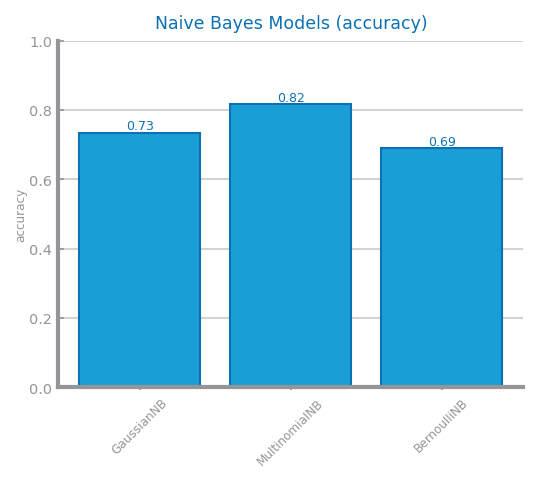

In [12]:
from numpy import array, ndarray
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart


def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list = []
    yvalues: list = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance = 0
    for clf in estimators:
        xvalues.append(clf)
        estimators[clf].fit(trnX, trnY)
        prdY: array = estimators[clf].predict(tstX)
        eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval - best_performance > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["name"] = clf
            best_params[metric] = eval
            best_model = estimators[clf]
        yvalues.append(eval)
        # print(f'NB {clf}')
    plot_bar_chart(
        xvalues,
        yvalues,
        title=f"Naive Bayes Models ({metric})",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params


figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, eval_metric)
savefig(f"images/{file_tag}_nb_{eval_metric}_study.png")
show()

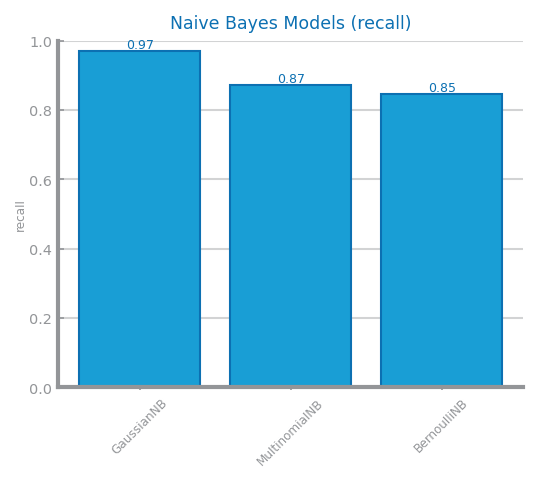

In [13]:
figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, "recall")
savefig(f"images/{file_tag}_nb_recall_study.png")
show()

<Figure size 600x450 with 0 Axes>

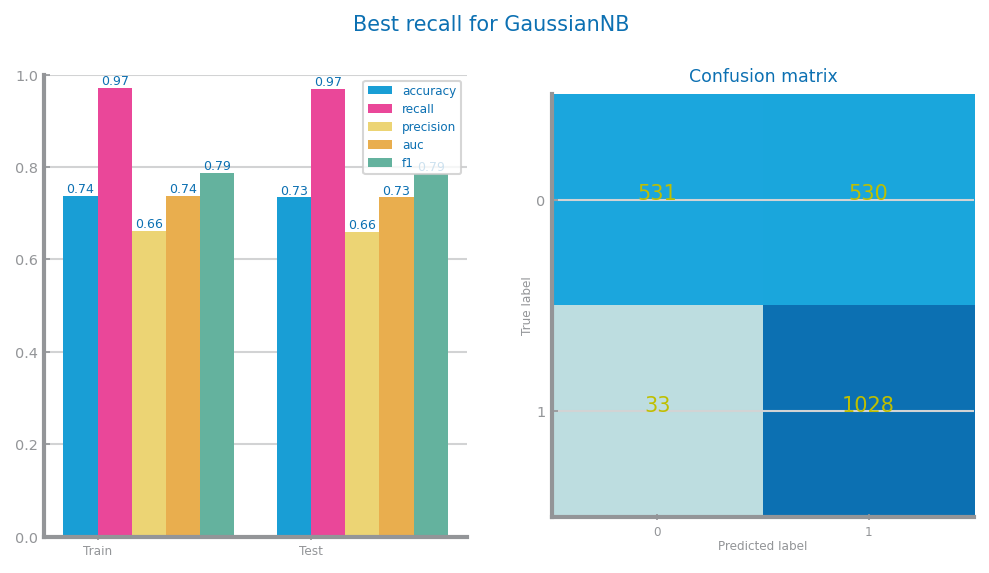

In [14]:
from dslabs_functions import plot_evaluation_results

prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_{params["name"]}_best_{params["metric"]}_eval.png')
show()

## KNN

Train#=4950 Test#=2122
Labels=[0, 1]
KNN best with k=1 and manhattan


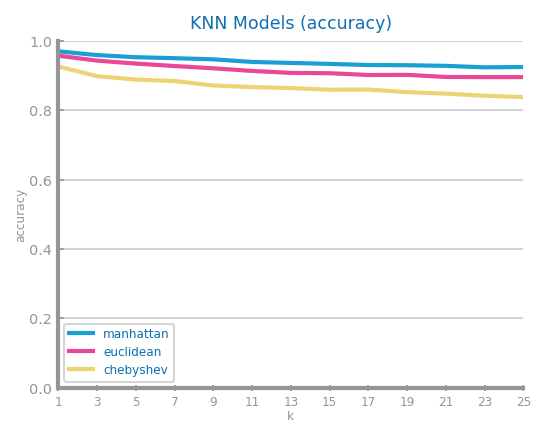

In [15]:
from typing import Literal
from numpy import array, ndarray
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_multiline_chart
from dslabs_functions import read_train_test_from_files, plot_evaluation_results

def knn_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, k_max: int=19, lag: int=2, metric='accuracy'
        ) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal['manhattan', 'euclidean', 'chebyshev']] = ['manhattan', 'euclidean', 'chebyshev']

    kvalues: list[int] = [i for i in range(1, k_max+1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {'name': 'KNN', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance: float = eval
                best_params['params'] = (k, d)
                best_model = clf
            # print(f'KNN {d} k={k}')
        values[d] = y_tst_values
    print(f"KNN best with k={best_params['params'][0]} and {best_params['params'][1]}")
    plot_multiline_chart(kvalues, values, title=f'KNN Models ({metric})', xlabel='k', ylabel=metric, percentage=True)

    return best_model, best_params

eval_metric = 'accuracy'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
savefig(f'images/{file_tag}_knn_{eval_metric}_study.png')
show()

### Best model performance

<Figure size 600x450 with 0 Axes>

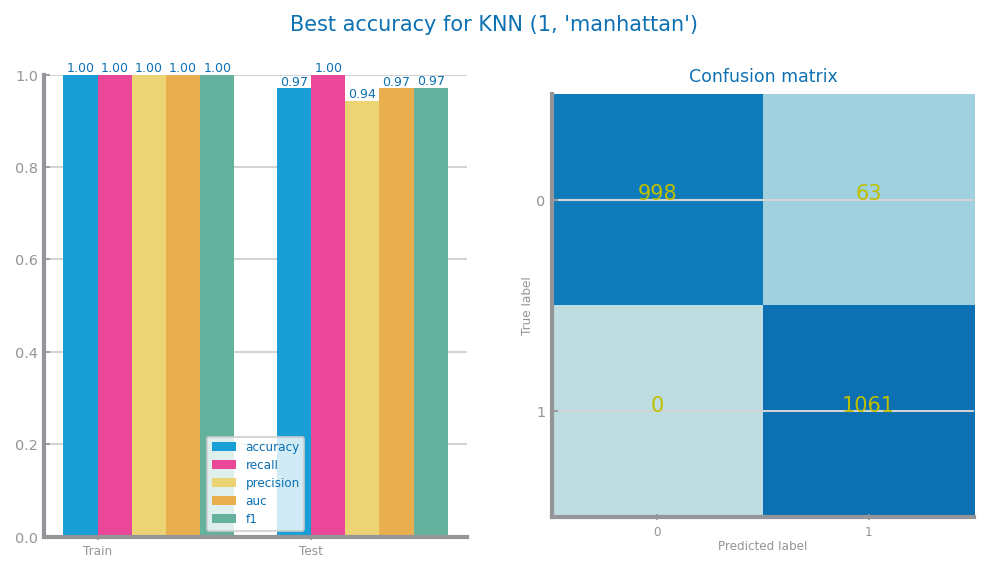

In [16]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_knn_{params["name"]}_best_{params["metric"]}_eval.png')
show()

### Overfitting study


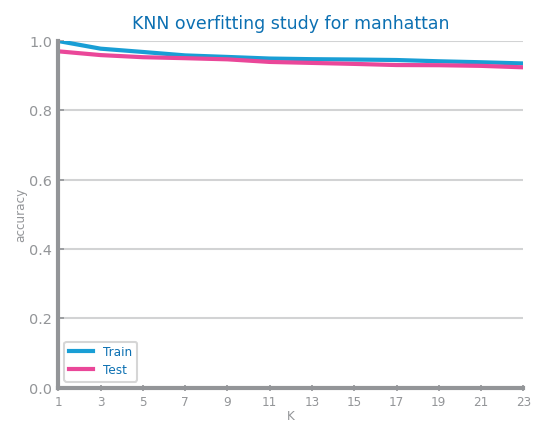

In [17]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = params["params"][1]
K_MAX = 25
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
acc_metric: str = "accuracy"
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_knn_overfitting.png")
show()

## Decision Tree

Train#=4950 Test#=2122
Labels=[0, 1]
Dropped column: 'Financial Distress'
DT best with entropy and d=24


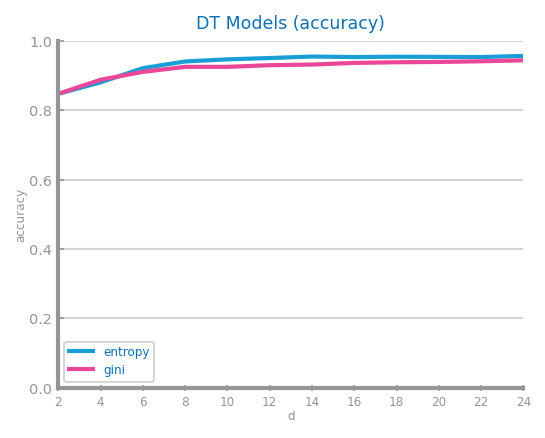

In [18]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import figure, savefig, show
from sklearn.tree import DecisionTreeClassifier
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, read_train_test_from_files
from dslabs_functions import plot_evaluation_results, plot_multiline_chart


def trees_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, d_max: int=10, lag:int=2, metric='accuracy'
        ) -> tuple:
    criteria: list[Literal['entropy', 'gini']] = ['entropy', 'gini']
    depths: list[int] = [i for i in range(2, d_max+1, lag)]

    best_model: DecisionTreeClassifier | None = None
    best_params: dict = {'name': 'DT', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict = {}
    for c in criteria:
        y_tst_values: list[float] = []
        for d in depths:
            clf = DecisionTreeClassifier(max_depth=d, criterion=c, min_impurity_decrease=0)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance = eval
                best_params['params'] = (c, d)
                best_model = clf
            # print(f'DT {c} and d={d}')
        values[c] = y_tst_values
    print(f"DT best with {best_params['params'][0]} and d={best_params['params'][1]}")
    plot_multiline_chart(depths, values, title=f'DT Models ({metric})', xlabel='d', ylabel=metric, percentage=True)

    return best_model, best_params

eval_metric = 'accuracy'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

# Drop the column 'Financial Distress' from both train and test feature sets
if 'Financial Distress' in vars:
    col_idx = vars.index('Financial Distress')  # Get the column index
    trnX = np.delete(trnX, col_idx, axis=1)     # Drop from train set
    tstX = np.delete(tstX, col_idx, axis=1)     # Drop from test set
    vars.pop(col_idx)                           # Remove column name from the list
    print("Dropped column: 'Financial Distress'")

figure()
best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric=eval_metric)
savefig(f'images/{file_tag}_dt_{eval_metric}_study.png')
show()

### Best model performance

<Figure size 600x450 with 0 Axes>

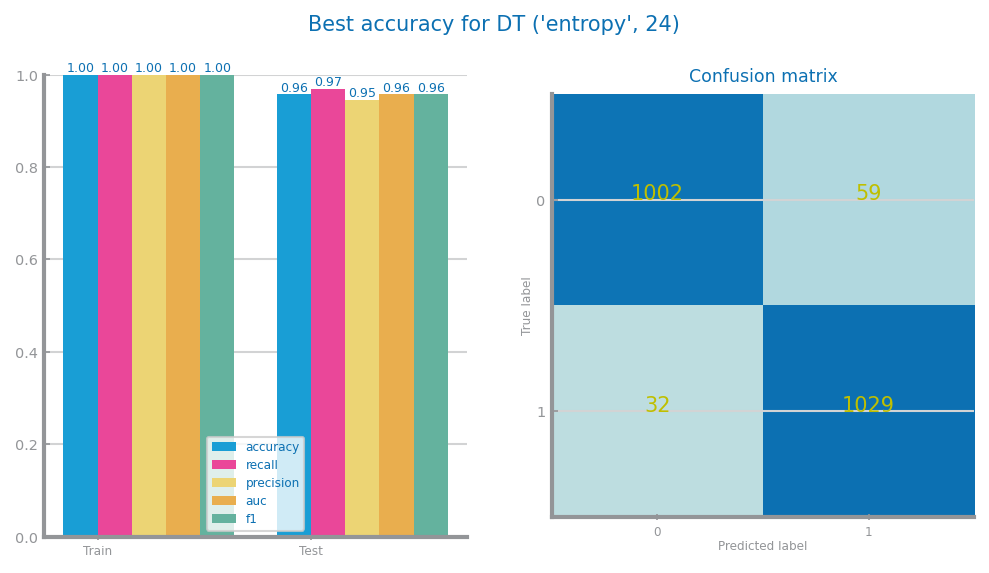

In [19]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
show()

### Variables importance

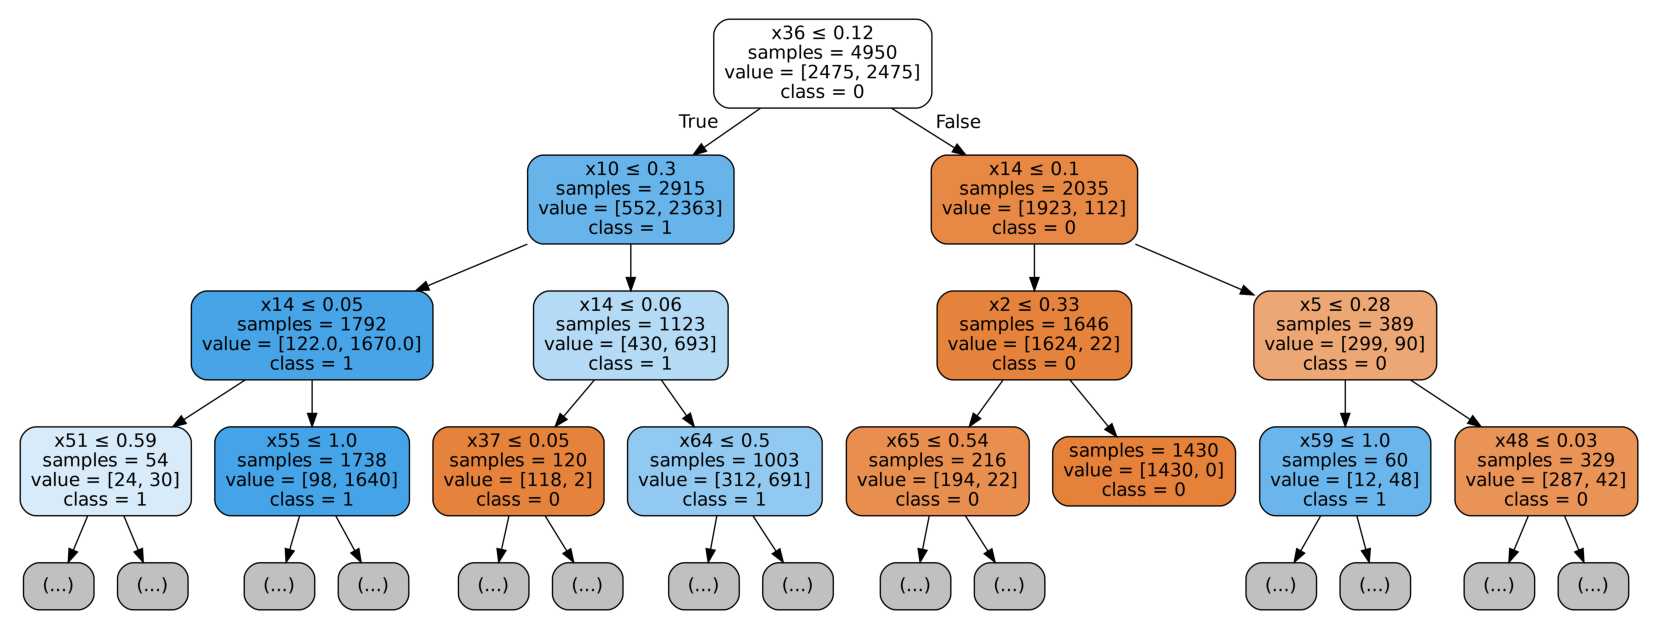

In [20]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{eval_metric}_best_tree"
max_depth2show = 3
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(14, 6))
imshow(imread(tree_filename + ".png"))
axis("off")
show()

1. x36 (0.4671011546705222)
2. x14 (0.08066339957513897)
3. x10 (0.07313507117940102)
4. x58 (0.023425903906018203)
5. x5 (0.02282704626863561)
6. x27 (0.019027158892624026)
7. x64 (0.018700707507329408)
8. x55 (0.017791054283413803)
9. x2 (0.015776571872544623)
10. x78 (0.015427952801904085)
11. x72 (0.013145219841968061)
12. x51 (0.013039580814413606)
13. x42 (0.012612963603965795)
14. x48 (0.012527920358844487)
15. x65 (0.01204068734388414)
16. x66 (0.011419664484640421)
17. Company (0.011146298126943458)
18. x77 (0.010306009974287766)
19. Time (0.008796318175507972)
20. x59 (0.008030903981929939)
21. x53 (0.007191792510760778)
22. x50 (0.0062604105665876155)
23. x37 (0.005793084805646701)
24. x28 (0.00562294596440068)
25. x83 (0.005271236764161248)
26. x82 (0.0052026740391542875)
27. x57 (0.005113542601128016)
28. x79 (0.004977131910838533)
29. x29 (0.004927421644853914)
30. x39 (0.004899446136486648)
31. x16 (0.0044068272318798845)
32. x56 (0.004187946710629756)
33. x35 (0.0039879

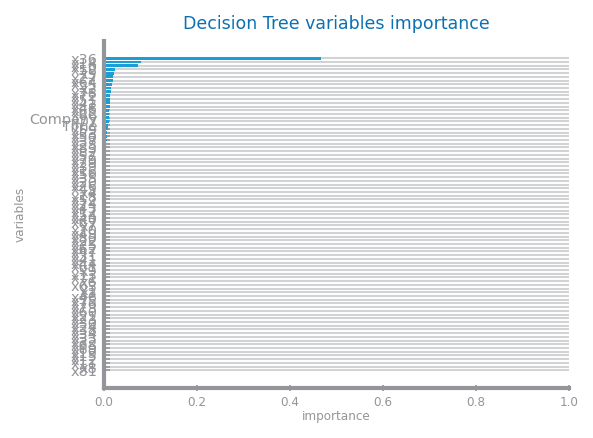

In [21]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title="Decision Tree variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{eval_metric}_vars_ranking.png")

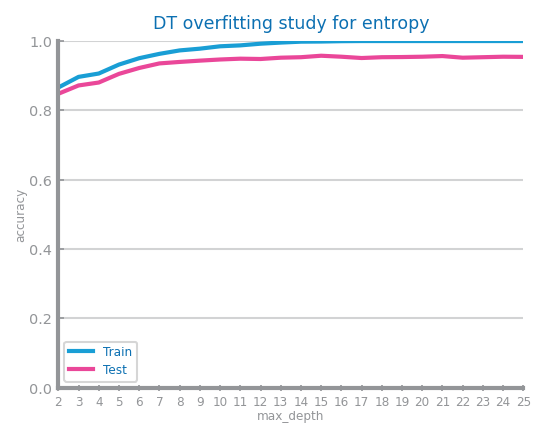

In [22]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{eval_metric}_overfitting.png")